# AM 207 Final Project
## Now I See You
### --- Sensor Based Single User Activity Recognition
<img src="plot/background.png", width=300>
#### Team members:
Xiaowen Chang: xiaowenchang@g.harvard.edu

Baijie Lu: blu@g.harvard.edu

Fangzheng Qian: fqian@g.harvard.edu

Yuhan Tang: tang01@g.harvard.edu

#### Assigned Teaching fellow: 

Xide Xia: xidexia@g.harvard.edu
###### Submitted as the final project of AM 207: Advanced Scientific Computing in Harvard University

# Table of Contents

* [0. Introduction](#0.-Introduction)
* [1. Data Engineering](#1.-Data-Engineering)
    * [1.1 Preprocessing](#1.1-Preprocessing)
    * [1.2 Activity Array](#1.2-Activity-Array)
    * [1.3 Feature Representation](#1.3-Feature-Representation)
        * [1.3.1 Raw](#1.3.1-Raw)
        * [1.3.2 ChangePoint](#1.3.2-ChangePoint)
        * [1.3.3 LastSensor](#1.3.3-LastSensor)
    * [1.4 Save Files](#1.4-Save-Files)
* [2. House and Feature Setting](#2.-House-and-Feature-Setting)
* [3. Naive Bayes Model](#3.-Naive-Bayes-Model)
    * [3.1 Parameter Estimation](#3.1-Parameter-Estimation)
    * [3.2 Prior](#3.2-Prior)
    * [3.3 Maximize Posterior](#3.3-Maximize-Posterior)
    * [3.4 Model Visualization](#3.4-Model-Visualization)
* [4. Hidden Markov Model (HMM)](#4.-Hidden-Markov-Model)
    * [4.1 First Order HMM](#4.1-First-Order-HMM)
    * [4.2 Second Order HMM](#4.2-Second-Order-HMM)
* [5. Model Comparison](#5.-Model-Comparison)

**This project is split into two parts --- DataEngineering.ipynb and Models.ipynb. You are looking at the Second part Models.ipynb. You need data generated by DataEngineering.ipynb to run this notebook.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import timeit
import json
%matplotlib inline

# 2. House and Feature Setting
### - Use different house data by setting house to 'A' or 'B' or 'C'
### - Use different feature representaton way by setting t to 'r' or 'c' or 'l'

In [27]:
def read_data(house, xtype):
    assert house in houses
    assert xtype in xtype_dict
    
    act_df = pd.read_csv("../data/house{}_act.csv".format(house))
    sensor_df = pd.read_csv("../data/house{}_sensor.csv".format(house))
    X = np.load("../data/X_{}_house{}.npy".format(xtype_dict[xtype], house))
    Y = np.load("../data/Y_house{}.npy".format(house))
    return act_df, sensor_df, X, Y

In [28]:
houses = ['A', 'B', 'C']
xtype_dict = {'r':'raw', 'c':'change', 'l':'last'}

In [143]:
house = 'C'
t = 'c'

In [144]:
#read in data
act_df,sensor_df,X,Y = read_data(house, t)

#build 4 dict, act to idx, idx to act, sensor to idx, idx to sensor
all_act = list(set(act_df.label)) + [0] #all the act labels
a2i = dict(zip(all_act, range(len(all_act))))
i2a = dict(zip(range(len(all_act)), all_act))

all_sensor = list(set(sensor_df.label))
i2s = dict(zip(range(len(all_sensor)), all_sensor))
s2i = dict(zip(all_sensor, range(len(all_sensor))))

# 3. Naive Bayes Model
<img src="plot/NB.png", width = 300>
Besides the conditional independence assumption, Naive Bayes Model also assumes all data points are independently and identically distributed, that is it doesn't consider the correlation between data points. 

The joint probability over the testing data points:
$$P(X_{1:T}|Y_{1:T})= \prod_{t=1}^T P(x_t|y_t)P(y_t)= \prod_{t=1}^T\prod_{n=1}^N\prod_{i=1}^D P(x_{tn}|y_t = i)P(y_t=i)$$
$$ = \prod_{t=1}^T\prod_{n=1}^N\prod_{i=1}^D  \pi_{ti}*\mu_{ni}^{x_{tn}}(1-\mu_{ni})^{1-x_{tn}}$$
where $\pi_{ti}$ is based on the frequencies of activity i during time slot t in the training data without taking any observed sensor data into account. 

MLE estimates for $\pi_{ti}$ are
$$\hat{\pi}_{ti} = \frac{|S\{y_t=i\}|} {|S|}$$
where $|S|$ denotes the number of elements in the training set S.

By maximizing the product of the joint probability with respect to $y_{1:T} =\{y_1,y_2,...,y_T\}$ over the data points, we could find a mapping between the observation data $x_{1:T} = \{x_1,x_2,...x_T\}$ and a sequence of activity labels $y_{1:T} =\{y_1,y_2,...,y_T\}$.

## 3.1 Parameter Estimation
### Estimation of $\mu$

The exact distribution of the observation would require $2^N$ parameters with N being the number of sensors used.  To simplify the problem, we applied Naive Bayes conditional independence assumption to all of our models, which means given the hidden state(activity) label the features are independent, i.e. 
$$P(x_t|y_t = i) = \prod_{n=1}^N P(x_{tn}|y_t=i)$$ which requires only N parameters for each activity.

Also, we modeled each sensor observation as an independent Bernoulli distribution so that 
$$P(x_{tn}|y_t = i) = \mu_{ni}^{x_{tn}}(1-\mu_{ni})^{1-x_{tn}}$$
The parameter $\mu_{ni}$ of each model could be learned  by maximizing likelihood(MLE), that is we find the $\hat{\mu}_{ni}$ that could maximize 
$$\prod_{t=1}^T P(x_{tn}|y_t = i) = \prod_{t=1}^T \mu_{ni}^{x_{tn}}(1-\mu_{ni})^{1-x_{tn}}$$
Then the estimation is given by:
$$\hat{\mu}_{ni} = \frac{\sum_{t=1}^T x_{tn}\mathbf{1}\{y_t=i\}}{\sum_{t=1}^T \mathbf{1}\{y_t=i\}}$$
The MLE estimator considers the parameter to be a constant and estimates a value that provide maximum support for the data.


In [17]:
def calc_miu(X, Y, all_sensor, all_act):
    assert len(X)==len(Y)
    
    num_act = len(all_act)
    num_sensor = len(all_sensor)
    a2i = dict(zip(all_act, range(num_act)))
    miu = np.zeros([num_act, num_sensor])
    for act in all_act:
        sensor = X[Y==act]
        for row in sensor:
            miu[a2i[act]] += row
        total = np.sum(Y==act)
        if total != 0:
            miu[a2i[act]] = miu[a2i[act]]/total
    return miu

In [47]:
miu = calc_miu(X,Y,all_sensor, all_act)
# save miu
np.save("../data/mu{}_{}.npy".format(house,t), miu)

# 3.2 Prior

Prior $\pi_{ti}$ is based on the frequencies of activity i during time slot t in the training data without taking any observed sensor data into account. \
MLE estimates for $\pi_{ti}$ are
$$\hat{\pi}_{ti} = \frac{|S\{y_t=i\}|} {|S|}$$
where $|S|$ denotes the number of elements in the training set S.\

In [145]:
timeslice = 60
start = min(min(act_df.start_sec), min(sensor_df.start_sec))
end = max(max(act_df.end_sec), max(sensor_df.end_sec))
if (end-start)%timeslice != 0:
    end = (1+(end-start)/timeslice)*timeslice + start
duration = end-start
i2m = {}
for i in range(len(all_act)):    
    i2m[i] = set(act_df[act_df['label']==i2a[i]]['meaning'])

In [150]:
zero_am_dict = {'A':1203894000, 'B':1203894000, 'C':1203894000 }
six_am_dict = {'A':1203915600, 'B':1248235200, 'C':1227157200}

In [151]:
num_t = len(X)
num_act = len(all_act)

HOUR = 60
MINUTE = 60
DAY = 60 * 24
NOT_LIKELY = 0
LESS_LIKELY = 1*5
LIKELY = 2*5
HIGHLY_LIKELY = 3*5
VERY_LIKELY = 4 *5
ALMOST_CERTAINLY = 8*5
# six_am of starting date of house A at Amsterdam
first_zero_am = zero_am_dict[house]
first_six_am = six_am_dict[house]
first_time_dict = {}
for i in range(24):
    first_time_dict[i] = (first_six_am - start)/MINUTE + (i-6) * MINUTE
    if first_time_dict[i]<0:
        first_time_dict[i] += 24 * HOUR
minute_hour_dict = {k:v for v,k in first_time_dict.items()}

prior = np.zeros((DAY,num_act))

first_leaving = (first_six_am + 2 * HOUR * MINUTE - start)/MINUTE
end_leaving = first_leaving + HOUR * (22-8)


reshape_shape = [num_t/DAY,DAY]
used_t = num_t/DAY*DAY
remain_t = num_t - used_t

used_Y = Y[:used_t]
remain_Y = Y[used_t:]
print "Used {} minutes, remains {} minutes, total {} minutes".format(used_Y.shape[0], remain_Y.shape[0], Y.shape[0])
used_Y = used_Y.reshape(reshape_shape)
for i in range(used_Y.shape[1]):
    day_activity = used_Y[:,i]
    unique, counts = np.unique(day_activity, return_counts=True)

    if i < remain_t:
        if remain_Y[i] in unique:
            counts[int(np.where(unique==remain_Y[i])[0])]+=1

        else:
            np.append(unique,int(remain_Y[i]))
            np.append(counts,1)
            print unique,counts
        for j,k in enumerate(unique):
            prior[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0])+1)
    else:
        for j,k in enumerate(unique):
            prior[i][a2i[int(k)]] = (counts[j])/(np.float(used_Y.shape[0]))

prior = np.tile(prior,(num_t/DAY,1))
prior = np.vstack((prior, prior[0:remain_t]))
prior.shape

Used 25920 minutes, remains 568 minutes, total 26488 minutes
[  0.  10.  28.] [ 1 16  1]
[  0.  10.  28.] [ 1 16  1]
[  0.  10.  28.] [ 1 16  1]
[  0.  10.  28.] [ 1 16  1]


(26488, 18)

### To give you a sense of how the prior distribution looks like, we plot the prior probability $P(y= Go to Bed)$ over different time slots as below:

In [152]:
sleep_dict={'A':5, 'B':5, 'C':7} #the index of 'go to bed' for different houses

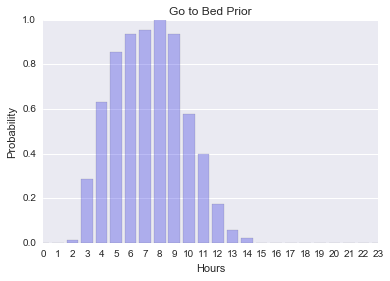

In [153]:
zero_start = first_time_dict[0]
day1 = np.arange(24)
day_bed = prior[:,sleep_dict[house]][zero_start:MINUTE * 24+zero_start].reshape(24,60)
day_hourly_bed = np.mean(day_bed,axis=1)
day_hourly_bed = np.roll(day_hourly_bed,2)
sns.barplot(day1,day_hourly_bed,color="b",alpha = 0.3)
plt.xticks(np.arange(0,24,1))
plt.xlim(0,23)
plt.xlabel('Hours')
plt.ylabel('Probability')
plt.title('Go to Bed Prior')

In [154]:
np.save('../data/Prior_{}'.format(house),prior)

## 3.3 Maximize Posterior

The joint probability over the testing data points:
$$P(X_{1:T}|Y_{1:T})= \prod_{t=1}^T P(x_t|y_t)P(y_t)= \prod_{t=1}^T\prod_{n=1}^N\prod_{i=1}^D P(x_{tn}|y_t = i)P(y_t=i)$$
$$ = \prod_{t=1}^T\prod_{n=1}^N\prod_{i=1}^D  \pi_{ti}*\mu_{ni}^{x_{tn}}(1-\mu_{ni})^{1-x_{tn}}$$

In [161]:
def max_posterior(mu, X, prior):
    num_time = len(X)
    num_act = len(mu)
    prob = np.zeros((num_time, num_act))
    for i in range(num_time):
        sensor = X[i]
        for j in range(num_act):
            act = mu[j]
            logp = 0
            for k,s in enumerate(sensor):
                if s == 1.:
                    logp += np.log(act[k])
                else:
                    logp += np.log(1-act[k])
            prob[i,j] = logp + np.log(prior[i , j])
    return prob

In [162]:
def NB(matrix):
    est = np.zeros(len(matrix))
    for i,row in enumerate(matrix):
        est[i] = np.argmax(row)
    return est

## 3.3 Model Evaluation
$$\text{Precision} = \frac{1}{N}\sum^N_i \frac{TP_i}{TI_i} $$
$$\text{Recall} = \frac{1}{N}\sum^N_i\frac{TP_i}{TT_i} $$
$$\text{F-Measure} = \frac{2 \cdot precision \cdot recal}{precision+recall} $$
$$\text{Accuracy} = \frac{\sum^N_i TP_i}{Total}$$

In [163]:
def precision(pred_label, Y):
    all_label = list(set(Y))
    N = len(all_label)
    res = 0
    for y in list(set(Y)):
        TP = np.sum(pred_label[Y==y]==y)
        TI = np.sum(pred_label==y)
        if TI != 0:
            res += (float(TP)/TI)
    return float(res)/N

def recall(pred_label, Y):
    all_label = list(set(Y))
    N = len(all_label)
    res = 0
    for y in list(set(Y)):
        TP = np.sum(pred_label[Y==y]==y)
        TT = np.sum(Y==y)
        if TT != 0:
            res += float(TP)/TT
    return float(res)/N

def f_score(pred_label, Y):
    p = precision(pred_label, Y)
    r = recall(pred_label, Y)
    return 2*p*r/(p+r)

def accuracy(pred_label, Y):
    res = 0
    all_label = list(set(Y))
    for y in list(set(Y)):
        TP = np.sum(pred_label[Y==y]==y)
        res += TP
    return float(res)/len(Y)

In [164]:
def result(miu, X, prior, act_df):
    likes = max_posterior(miu,X,prior)
    result = NB(likes) #note: result is index, not label yet
    #convert index to label
    all_act = list(set(act_df.label)) + [0] #all the act labels
    i2a = dict(zip(range(len(all_act)), all_act)) #ind to act dict
    res_label = np.array([i2a[e] for e in result])
    return res_label,likes

In [165]:
def evaluation(house,res_label, Y):
    print 'Precision: ',precision(res_label, Y)
    print 'Recall:', recall(res_label, Y)
    print 'F score: ', f_score(res_label, Y)
    print 'Accuracy:', accuracy(res_label, Y)

In [166]:
miu = np.load("../data/mu{}_{}.npy".format(house, t))
prior = np.load('../data/Prior_{}.npy'.format(house))
res_label,posterior = result(miu, X, prior, act_df)
# Evaluation
print 'Naive Bayes:' 
print 'House {} with Feature Representaton {}:'.format(house,t)
evaluation(house,res_label, Y)

House C with Feature Representaton c:
Precision:  0.716180378285
Recall: 0.432146479634
F score:  0.539036123947
Accuracy: 0.735238598611


## 3.4 Model Visualization

To visualize the performance of this Naive Bayes model, we plotted the prior probability, posterior probability and true probability of the activity 'go to bed' during different hours using our testing data. This plot could show us how did Naive Bayes model improved the prediction by taking observed sensor data into account.


In [167]:
true_act = np.zeros((len(Y),num_act))
for j,i in enumerate(Y):
    act_ = a2i[i]
    true_act[j,a2i[i]] += 1
true_act/=np.sum(true_act,axis = 1).reshape(len(Y),1)

In [168]:
first_two_days_probs = np.exp(posterior[:2*1440])
first_two_days_probs = first_two_days_probs/np.sum(first_two_days_probs, axis = 1).reshape(len(first_two_days_probs),1)

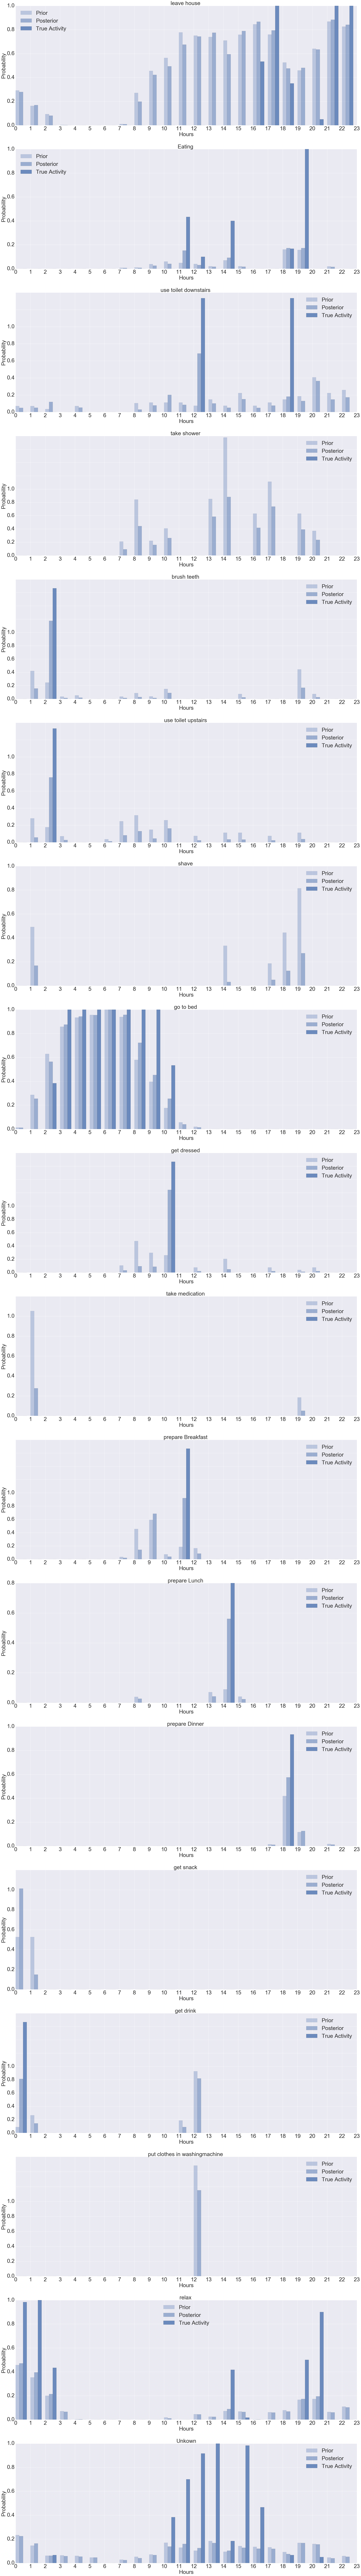

In [169]:
day1 = np.arange(24)
fig, ax = plt.subplots(num_act,1,figsize = (40,300))
zero_start = first_time_dict[0]

for i,j in i2m.iteritems():
    width = 0.25
    day_prior = prior[:,i][zero_start:MINUTE * 24+zero_start].reshape(24,60)
    day_posterior = first_two_days_probs[:,i][zero_start:MINUTE * 24+zero_start].reshape(24,60)
    day_true = true_act[:,i][zero_start:MINUTE * 24+zero_start].reshape(24,60)


    ax[i].bar(day1,np.mean(day_prior,axis=1),width,alpha = 0.3,label = 'Prior')
    ax[i].bar(day1+width,np.mean(day_posterior,axis=1),width, alpha = 0.5, label = 'Posterior')
    ax[i].bar(day1+width*2,np.mean(day_true,axis=1),width, alpha = 0.8,  label = 'True Activity')
    ax[i].set_xticks(np.arange(0,24,1))
    ax[i].set_xlim(0,23)
    ax[i].set_xticklabels(np.arange(0,24,1), fontsize = 36)
    ax[i].set_yticklabels(np.arange(0,1.01,0.2), fontsize = 36)
    ax[i].set_xlabel('Hours',fontsize = 36)
    ax[i].set_ylabel('Probability',fontsize = 36)
    try:
        ax[i].set_title('{} '.format(list(j)[0]),fontsize = 36)
    except:
        ax[i].set_title('Unkown',fontsize = 36)
    ax[i].legend(loc = 'best',fontsize = 36)

# 4. Hidden Markov Model
In Naive Bayes model, we assumes all data points are independently and identically distributed. However, it is not true. The data we have are time series data and there exists a temporal correlation between consecutive time slices. A Hidden Markov Model (HMM) can be used to explore this scenario. In an HMM model, we have a series of observed outputs $X={x_1, x_2, ...,x_t}$ drawn from a series of hidden state $Y={y_1, y_2, ..,y_t}$. In this problem, X should be the observed sensor states and Y should be the activity states. 

In [174]:
# define function to fit HMM model

def HMM(house, X_train, Y_train, X_test, Y_test, order):

    # Initialization
    activity_single = [int(x) for x in list(set(Y_train))] + [0]
    activity_higher = [prod for prod in itertools.product(*np.tile(activity_single, (order,1)))]

    A = len(activity_single)
    K = len(activity_higher)
    S = X_train.shape[1]
    N_train = len(X_train)
    N_test = len(Y_test)
    
    index_to_single = dict(zip(range(A), activity_single)) #ind to activity_single dict
    single_to_index = dict(zip(activity_single, range(A))) #activity_single to ind dict
    index_to_higher = dict(zip(range(K), activity_higher)) #ind to activity_higher dict
    higher_to_index = dict(zip(activity_higher, range(K))) #activity_higher to ind dict

    
    # Training transition and emission
    transition_count = np.zeros((K, K)) + 0.00001
    emission_count = np.zeros((K, S, 2)) + 0.00001

    for i in range(order-1, N_train-1):
        yi = higher_to_index[tuple(Y_train[i-order+1:i+1])]
        ynext = higher_to_index[tuple(Y_train[i-order+2:i+2])]
        transition_count[yi, ynext] += 1

        xi = X[i]
        for j in range(S): 
            emission_count[yi, j, int(xi[j])] += 1

    higher_last = higher_to_index[tuple(Y_train[-order:])]
    for j in range(S): 
        emission_count[higher_last, j, int(X[-1][j])] += 1
        
    transition = transition_count/np.sum(transition_count, axis=1).reshape(K,1)
    log_transition = np.log(np.nan_to_num(transition))

    emission = emission_count/np.sum(emission_count, axis=2).reshape(K,S,1)
    log_emission = np.log(np.nan_to_num(emission))[:,:,0].reshape(K,S)

    
    # Viterbi
    ### Initial probability
    initial = np.zeros(K)
    initial[higher_to_index[tuple(Y_test[:order])]] = 1
    log_initial = np.log(initial)
    
    ### Initialize T1 and T2
    T1 = np.zeros((K,N_test-order+1))
    T2 = np.zeros((K,N_test-order+1))

    calc_emission = lambda p, x:  np.power(p,(1-x))*np.power((np.log(1-np.exp(p))),x)
    T1[:,0] = log_initial + np.sum(calc_emission(log_emission, X_train[order-1]), axis=1)

    ### Update T1 and T2
    for i in range(1, N_test-order+1):
        obj = T1[:, i-1].reshape(K,1) + log_transition + np.sum(calc_emission(log_emission, X_train[i+order-1]), axis=1)
        T1[:,i] = np.max(obj, axis=0)
        T2[:,i] = np.argmax(obj, axis=0)
        
    ### Back-fill the most likely state
    Z = np.zeros(N_test-order+1)
    Z[-1] = np.argmax(T1[:,-1])

    for i in range(-1, -(N_test-order), -1):
        Z[i-1] = T2[int(Z[i]), i]

    Y_HMM = np.array([index_to_higher[i][0] for i in Z])
    Y_HMM[0] = Y_test[:order][0]
    
    
    # Output results
    result = evaluation(house, Y_HMM, Y_train[:N_test-order+1])

# 4.1 First Order HMM

<img src="plot/hmm1.png", width =300>
The First Order HMM relies on the following three assumptions:

**Limited Horizon Assumption:** the probability of being in a hidden state at time t depends only on the hidden state at time t-1.

**Stationary Process Assumption:** the conditional distribution over next hidden state given current hidden state does not change over time. 

**Output Independence Assumption:** the output observation at time t is dependent
only on the current hidden state.

From this HMM, we want to know what is the most likely series of states  $y_{1:T} = \{y_1,y_2,...,y_T\}$ given an observed series of observed sensor data $x_{1:T} = \{x_1,x_2,...x_T\}$. Formally, we seek:
$$arg max_{Y} P(Y|X; A, B) = arg max_{Y} \prod_{t=1}^{T} \frac{P(y_t, x_t; A, B)}{\sum_{Y} P(y_t,x_t; A,B)}= arg max_{Y} \prod_{t=1}^{T} P(y_t, x_t; A, B)$$
$$ \prod_{t=1}^{T} P(y_t, x_t) = \prod_{t=1}^T P(x_t|y_t)P(y_t|y_{t-1})=\prod_{t=1}^T\prod_{n=1}^N\prod_{i=1}^D P(x_{tn}|y_t = i)P(y_t=i|y_{t-1})$$
where A is the transition matrix and B is the emission matrix. To simplify the notation, we used $P(y_1|y_0)=P(y_1)$. The element $a_{ij}$ in matrix A represents $P(y_t=j|y_{t-1}=i)$. The element $b_{in}$ in matrix B represents $P(x_{tn}|y_t=i)$, which is equivalent to $\mu_{ni}$.  The transition probability $a_{ij}=P(y_t=j|y_{t-1}=i)$ is a multinomial distribution and $a_{ij}$ is given by:
$$\hat{a}_{ij} = \frac{\sum_{t=1}^T \mathbf{1}\{y_t=j\}\mathbf{1}\{y_{t-1}=i\}}{\sum_{t=1}^T \mathbf{1}\{y_{t-1}=i\}}$$
To solve the argmax equation, naively, we could try every possible assignment to Y and take the one with highest value of joint probability. However, it would require $\mathcal{O}(|Y|^T)$ operations. So instead, we used a dynamic programming algorithm called Viterbi to solve this equation. 

In [177]:
order = 1
all_result = []

X_train = X
Y_train = Y
X_test = X
Y_test = Y
print 'First Order HMM:'
print 'House {} with Feature Representaton {}:'.format(house,t)
HMM(house, X_train, Y_train, X_test, Y_test, order)

First Order HMM:
House C with Feature Representaton c:
Precision:  0.476879915639
Recall: 0.510183405339
F score:  0.492969831069
Accuracy: 0.787941709453


# 4.2 Second Order HMM

<img src="plot/hmm2.png", width =300>
The order of a HMM is the length of history upon which the probabilities of the possible values of the next state depend. The only difference between 1st and 2nd order HMM is that 2nd order HMM depends upon the two previous states. Thus, the probability of transitioning to a new state depends not only on the current state, but also on the previous state. This allows a more realistic context dependence.

We could rewrite our likelihood as following:
$$ \prod_{t=1}^{T} P(y_t, x_t) = \prod_{t=1}^T P(x_t|\{y_t, y_{t-1}\})P(\{y_t,y_{t-1}\}|\{y_{t-1},y_{t-2}\})$$
$$=\prod_{t=1}^T\prod_{n=1}^N\prod_{\{i,j\}=\{1,1\}}^{D^2} P(x_{tn}|\{y_t, y_{t-1}\} = \{i,j\})P(\{y_t, y_{t-1}\} = \{i,j\}|\{y_{t-1}, y_{t-2}\}) $$
We could used the same Viterbi algorithm as 1st order HMM with different Transition matrix and Emission matrix to find the maximum likelihood assignment for 2nd order HMM. 
Instead of using D different activities as our hidden states, we used all combinations of 2 activities as our hidden states in 2nd order HMM, which has a size of $D^2$. Thus,
$$\hat{a}_{ij, jk} = \frac{\sum_{t=2}^T \mathbf{1}\{\{y_t,y_{t-1}\}=\{j,k\}\}\mathbf{1}\{\{y_{t-1},y_{t-2}\}=\{i,j\}\}}{\sum_{t=2}^T \mathbf{1}\{\{y_{t-1},y_{t-2}\}=\{i,j\}\}}$$
$$\hat{b}_{ij,n} = \frac{\sum_{t=1}^T x_{tn}\mathbf{1}\{\{y_t,y_{t-1}\}=\{i, j\}\}}{\sum_{t=1}^T \mathbf{1}\{\{y_t,y_{t-1}\}=\{i, j\}\}}$$

In [179]:
order = 2
all_result = []

X_train = X
Y_train = Y
X_test = X
Y_test = Y
print 'Second Order HMM:'
print 'House {} with Feature Representaton {}:'.format(house,t)
HMM(house, X_train, Y_train, X_test, Y_test, order)

Second Order HMM:
House C with Feature Representaton c:
Precision:  0.579954081248
Recall: 0.599401288809
F score:  0.589517345791
Accuracy: 0.79552233171


# 5. Model Campariosn
Using the four metrics above to visualize the performance of our models, we plotted the performance heat map for different houses. Here we used the performance heat map of house A as an example.

<img src="plot/result.png"|>

Naive Bayes is the simplest model without taking time factor into account while HMM add temporal relations. However, from the result above, we did not see a significant performance improvement. This might be because HMM model needs more training data to accurately learn the parameters. 

Also we noticed that the choice of feature representation strongly affects the recognition performance. It is hard to see when one activity ends and another one starts using raw data feature representation and it does not provide good information about the activity currently performed. For example, the observed open his laptop doing some work and then go to sleep without closing his laptop then the raw representation can indicate that the laptop is open long after the person finished using the laptop. The ChangePoint representation can solve this issue because it only indicates the moment the sensor changes its value. However, unless another sensor fired, it can not differentiate whether the person is currently doing the activity or already finished so it does not perform very well in Naive Bayes model. LastSensor representation solved this issue and thus improved the performance of Naive Bayes model.

In terms of future work, more complex model like Hidden semi-Markov model, Conditional Random Fields, Neutral Network could be tried to improve the recognition performance. 